In [29]:
from __future__ import print_function
import librosa
import numpy as np
import matplotlib.pyplot as plt
import json
from statistics import stdev
%matplotlib inline
#from songloader import *
#from slidingwindowgen import *

In [2]:
samples_per_chunk = 300
num_chunks_per_slice = 65
num_chunks_per_beat = 8

In [3]:
def loadbeatmap_3dout(beatmap, num_beats, num_chunks_per_beat=8):
    if beatmap[len(beatmap)-5:len(beatmap)] != ".json":
        print("Beatmap file " + audio + " is not of type .json")
        return -1
    
    with open(beatmap) as f:
        data = json.load(f)
  
    notes = "_notes"
    time = "_time"
    line_index = "_lineIndex" #column number
    line_layer = "_lineLayer" #row number
    note_color = "_type" #0 is one color and 1 is the other
    cut_direction = "_cutDirection"#9 cut directions

    dim_0 = num_beats * num_chunks_per_beat
    
    # number of rows and columns in the playfield
    # number of cells in the playfield (each cell can hold at most 1 note)
    playfield_rows = 3
    playfield_cols = 4
    playfield_cell_count = playfield_rows * playfield_cols
    
    # number of colors (2): red, blue (order unknown)
    # number of directions notes can face (9): 
    # up, down, left, right, up-left, up-right, down-left, down-right, dot (order unknown)
    note_color_count = 2
    note_direction_count = 9
    
    # dimensions for a 'one-hot' representation of a single time unit (chunk)
    dim_1 = playfield_rows
    dim_2 = playfield_cols
    dim_3 = (note_color_count + 1) + note_direction_count
    
    # initialize matrix to zeros, then set the "no note" bit for each block at each timestep to 1
    outMatrix = np.zeros(shape=(dim_0, dim_1, dim_2, dim_3))
    outMatrix[:,:,:,0] = 1
    

    # for every note in the beatmap, set the color and direction bits for the proper cell to 1
    for n in range(len(data[notes])):
        entry = int(np.round(data[notes][n][time]*num_chunks_per_beat)) #convert time to row index by rounding to nearest 1/8 beat
        if data[notes][n][note_color] < 2:
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [data[notes][n][note_color]+1] = 1
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [0] = 0
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [data[notes][n][cut_direction]+3] = 1

    return outMatrix

In [266]:
def mean_center(x): 
    #return x - np.mean(x)
    return (x - np.apply_along_axis(np.mean, 0, x) )/ np.apply_along_axis(np.std, 0, x)

In [300]:
def encode_note_color(x):
    return (np.max(x[:,:,0])*1+ np.max(x[:,:,1])*2)

In [4]:
def loadsong(audio, samples_per_chunk=300, num_chunks_per_slice=65, num_chunks_per_beat=8, verbose=0):
    if audio[len(audio)-4:len(audio)] != ".ogg":
        print("Audio file " + audio + " is not of type .ogg")
        return -1
    
    y, sr = librosa.load(audio)
    
    song_length = librosa.get_duration(y=y,sr=sr) / 60.0
    tempo = np.round(librosa.beat.tempo(y, sr=sr))
    new_sample_rate = (tempo/200)*8000
    
    y = librosa.resample(y, sr, new_sample_rate)
    
    number_of_beats = int(tempo * song_length)
    
    #y = transformsong(y, number_of_beats, song_length, num_chunks_per_beat)
    
    #y_bm = loadbeatmap_3dout(beatmap, number_of_beats)

    
    return y[0:(len(y)//(samples_per_chunk*num_chunks_per_beat)*(samples_per_chunk*num_chunks_per_beat))], new_sample_rate, number_of_beats#, y_bm

In [5]:
#song1_y, song1_sr, song1_num_beats = loadsong("song.ogg")
song0_y, song0_sr, song0_num_beats = loadsong("song.ogg")

/nfshome/apps/python-3.6.7/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [238]:
song1_y = song0_y
song1_sr = song0_sr
song1_num_beats = song0_num_beats

In [239]:
np.shape(song1_y)

(1233600,)

In [240]:
song1_y = song1_y.reshape(len(song1_y)//300,300)

In [241]:
np.shape(song1_y)

(4112, 300)

In [242]:
song1_fft = np.abs(np.apply_along_axis(np.fft.fft, 1, song1_y))[:,0:(int)(samples_per_chunk/2)+1]

In [243]:
np.shape(song1_fft)

(4112, 151)

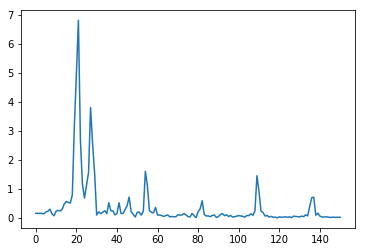

In [244]:
plt.plot(range(len(song1_fft[100])),song1_fft[50])

fig,axes = plt.subplots(50) 
#fig.set_figwidth(12) 
fig.set_figheight(20)
for x in range(50):
    #data = plt.plot(range(len(song1_fft[100])),song1_fft[50+x])
    axes[x].plot(range(len(song1_fft[100])),song1_fft[1000+x]) 
        
plt.show()

In [245]:
beatmap1 = loadbeatmap_3dout("Expert.json", song1_num_beats)

In [246]:
beatmap1[644]

array([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [275]:
np.shape(beatmap1)

(4112, 3, 4, 12)

In [291]:
beatmap1_slice = beatmap1[:,:,:,1:3]

In [292]:
beatmap1_slice[644]

array([[[0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]])

In [302]:
np.shape(beatmap1_slice)

(4112, 3, 4, 2)

In [301]:
beatmap1_encoded = np.apply_along_axis(encode_note_color, 0, beatmap1_slice)

IndexError: too many indices for array

In [305]:
beatmap1_encoded = np.array([encode_note_color(x) for x in beatmap1_slice])

In [306]:
np.shape(beatmap1_encoded)

(4112,)

In [310]:
beatmap1_encoded[600:650]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.])

In [299]:
np.max(beatmap1_slice[644][:,:,0])*1+ np.max(beatmap1_slice[644][:,:,1])*2

3.0

In [294]:
np.max(beatmap1_slice[644][1])

1.0

In [247]:
song1_fft = song1_fft[:,0:(int)(samples_per_chunk/2)+1]

In [248]:
np.shape(np.apply_along_axis(np.mean, 0, song1_fft))

(151,)

In [249]:
np.shape(song1_fft[0])

(151,)

In [264]:
song1_fft_mc = np.apply_along_axis(mean_center, 0, song1_fft)

In [267]:
song1_fft_mc_norm = np.apply_along_axis(mean_center, 0, song1_fft_mc )

In [272]:
song1_fft[1000:1002,0:10]

array([[ 2.60249719,  5.55299721, 14.24073188, 58.52945863, 44.67561485,
        16.69044402, 11.44465889, 19.65340455,  9.26986225,  9.67416591],
       [ 8.5659462 ,  8.93780402, 15.89725549, 59.76338357, 44.70495964,
        18.77857799, 13.57545113,  3.81930936,  4.27320044,  5.3479457 ]])

In [276]:
U,S,V = np.linalg.svd(song1_fft_mc_norm,full_matrices=True)
# Percent variance accounted for


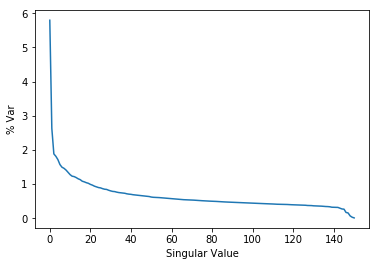

In [277]:
plt.plot(100.0*S/np.sum(S))
plt.ylabel('% Var')
plt.xlabel('Singular Value')
plt.show()

In [288]:
# Variance accounted for in the first two principal components
100.0*(np.sum(S[:2]))/np.sum(S)

8.431197311388523

In [368]:
X = song1_fft_mc_norm
Y = beatmap1_encoded

D = np.zeros([X.shape[0],X.shape[1]])
np.fill_diagonal(D,S)
Xrotated = np.dot(U,D)

PCs = Xrotated[:,0:149] 
PCs.shape

(4112, 149)

In [369]:
PCs

array([[-1.01096824e+01, -1.17044652e+00,  1.27023258e-01, ...,
        -3.67393946e-03, -1.04234370e-03,  4.47505753e-03],
       [-1.01096824e+01, -1.17044652e+00,  1.27023258e-01, ...,
        -3.67393946e-03, -1.04234370e-03,  4.47505753e-03],
       [-1.01096824e+01, -1.17044652e+00,  1.27023258e-01, ...,
        -3.67393946e-03, -1.04234370e-03,  4.47505753e-03],
       ...,
       [-1.01096824e+01, -1.17044652e+00,  1.27023258e-01, ...,
        -3.67393946e-03, -1.04234370e-03,  4.47505753e-03],
       [-1.01096824e+01, -1.17044652e+00,  1.27023258e-01, ...,
        -3.67393946e-03, -1.04234370e-03,  4.47505753e-03],
       [-1.01096824e+01, -1.17044652e+00,  1.27023258e-01, ...,
        -3.67393946e-03, -1.04234370e-03,  4.47505753e-03]])

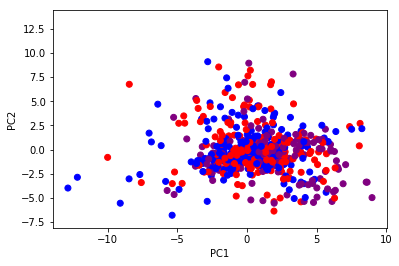

In [374]:
plt.scatter(PCs[:,2],PCs[:,3],
            color=[['none','red','blue','purple'][i] for i in Y.astype(int)])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

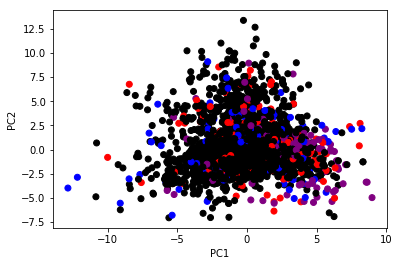

In [375]:
plt.scatter(PCs[:,2],PCs[:,3],
            color=[['black','red','blue','purple'][i] for i in Y.astype(int)])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [371]:
PCs_2_X = np.array([x for x in PCs if x[0] < 16 and x[1] < 6])
PCs_2_Y = np.array([Y[i] for i in range(len(Y)) if PCs[i,0] < 16 and PCs[i,1] < 6] )

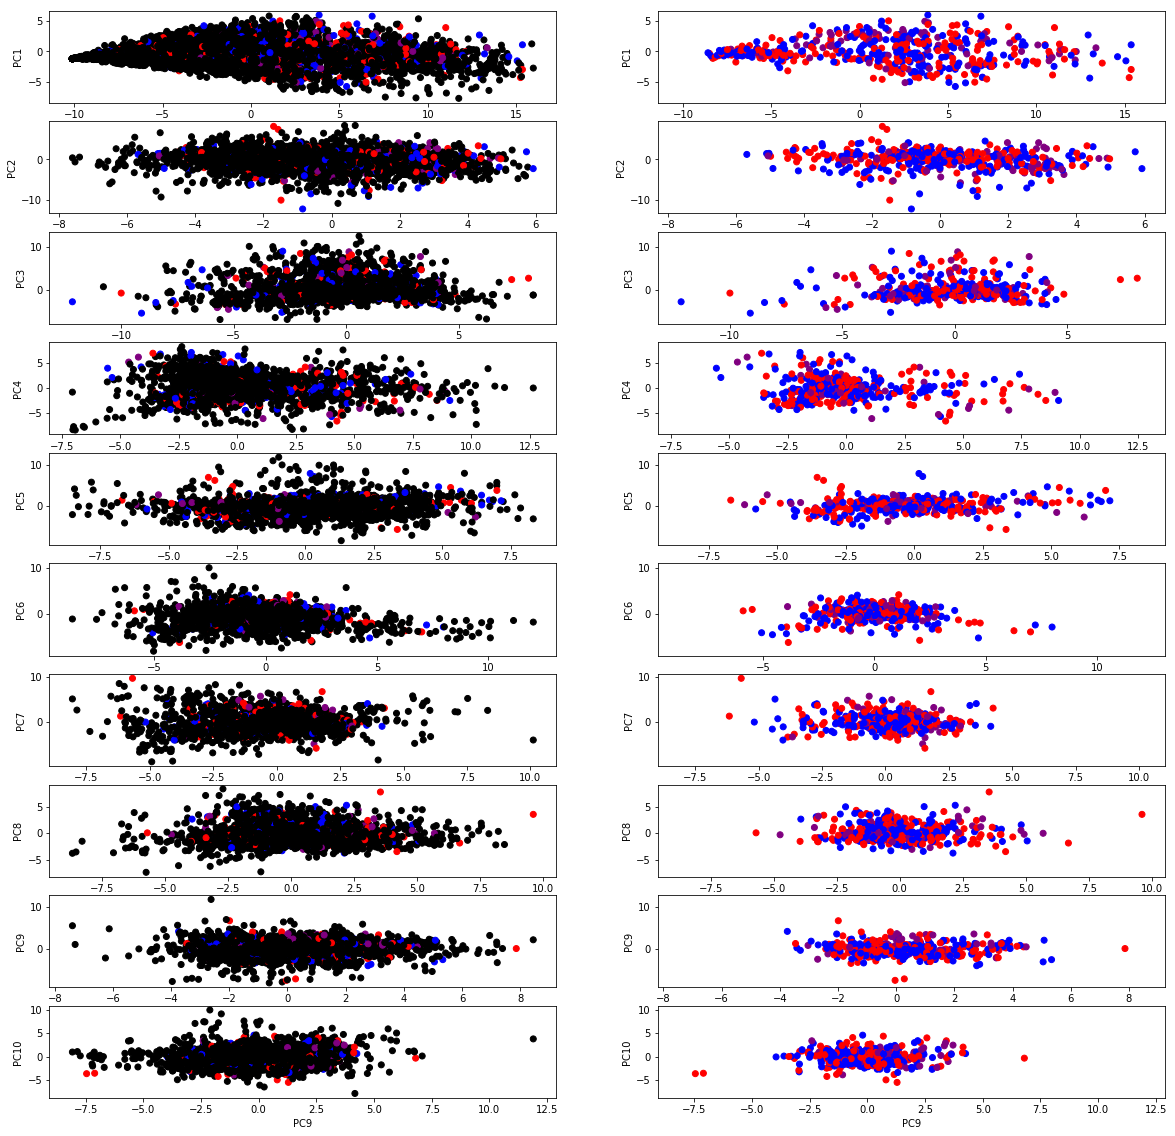

In [364]:
fig,axes = plt.subplots(10,2) 
fig.set_figwidth(20) 
fig.set_figheight(20)
for x in range(10):
    for y in range(2):
        start = x
        slice = (start, start+1)
        if y == 0:
            axes[x,y].scatter(PCs_2_X[:,slice[0]],PCs_2_X[:,slice[1]],
                    color=[['black','red','blue','purple'][i] for i in PCs_2_Y.astype(int)])
            axes[x,y].set_xlabel(str("PC"+str(slice[0])))
            axes[x,y].set_ylabel(str("PC"+str(slice[1])))
        else:
            axes[x,y].scatter(PCs_2_X[:,slice[0]],PCs_2_X[:,slice[1]],
                    color=[['none','red','blue','purple'][i] for i in PCs_2_Y.astype(int)])
            axes[x,y].set_xlabel(str("PC"+str(slice[0])))
            axes[x,y].set_ylabel(str("PC"+str(slice[1])))


            
plt.show()

#start = 5
#slice = (start, start+1)
#plt.scatter(PCs_2_X[:,slice[0]],PCs_2_X[:,slice[1]],
#            color=[['none','red','blue','purple'][i] for i in PCs_2_Y.astype(int)])
#plt.xlabel(str("PC"+str(slice[0])))
#plt.ylabel(str("PC"+str(slice[1])))
#plt.show()

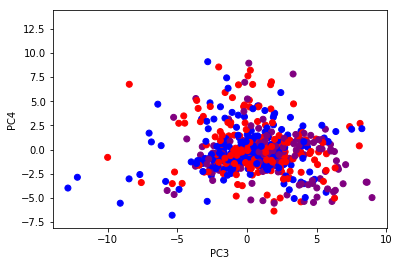

In [340]:
plt.scatter(PCs[:,2],PCs[:,3],
            color=[['none','red','blue','purple'][i] for i in Y.astype(int)])
plt.xlabel("PC3")
plt.ylabel("PC4")
plt.show()

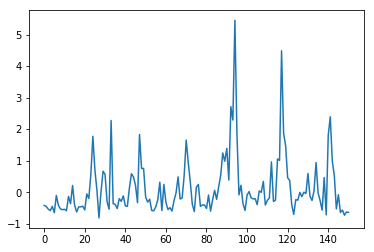

In [274]:
plt.plot( range(len(song1_fft_mc_norm[1000])) , song1_fft_mc_norm[2000] )

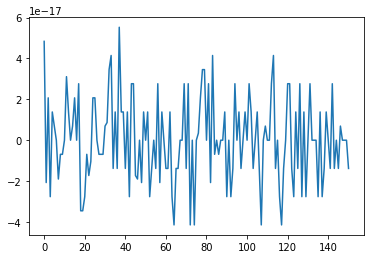

In [268]:
plt.plot( range(len(song1_fft_mc_norm[0])) , np.apply_along_axis(np.mean, 0, song1_fft_mc_norm) )

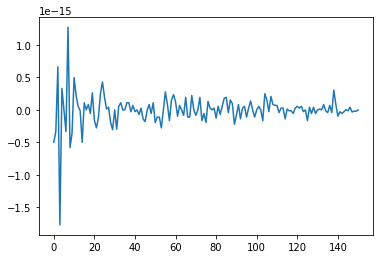

In [265]:
plt.plot( range(len(song1_fft_mc[0])) , np.apply_along_axis(np.mean, 0, song1_fft_mc) )

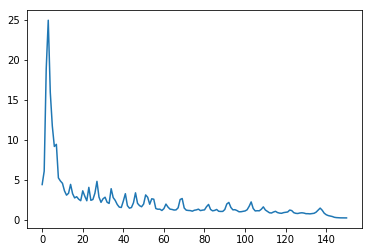

In [250]:
plt.plot( range(len(song1_fft[0])) , np.apply_along_axis(np.mean, 0, song1_fft) )

In [251]:
np.shape(song1_fft)

(4112, 151)

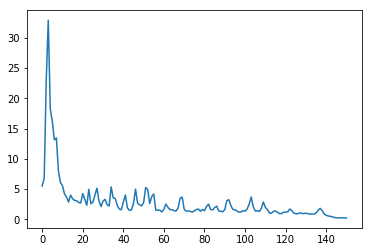

In [254]:
plt.plot(range(len(song1_fft[0])),np.apply_along_axis(np.std, 0, song1_fft))

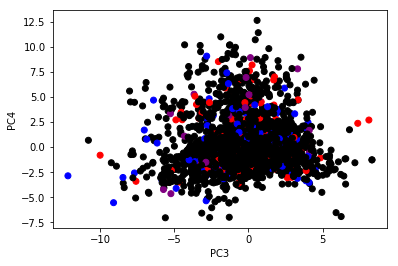

In [337]:
plt.scatter(PCs_3_4_X[:,2],PCs_3_4_X[:,3],
            color=[['black','red','blue','purple'][i] for i in PCs_3_4_Y.astype(int)])
plt.xlabel("PC3")
plt.ylabel("PC4")
plt.show()

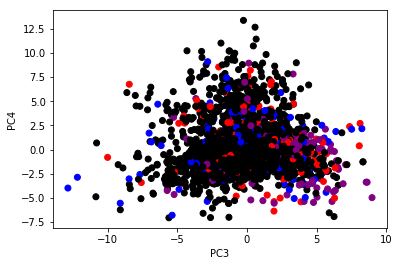

In [338]:
plt.scatter(PCs[:,2],PCs[:,3],
            color=[['black','red','blue','purple'][i] for i in Y.astype(int)])
plt.xlabel("PC3")
plt.ylabel("PC4")
plt.show()

IndexError: index 149 is out of bounds for axis 1 with size 149

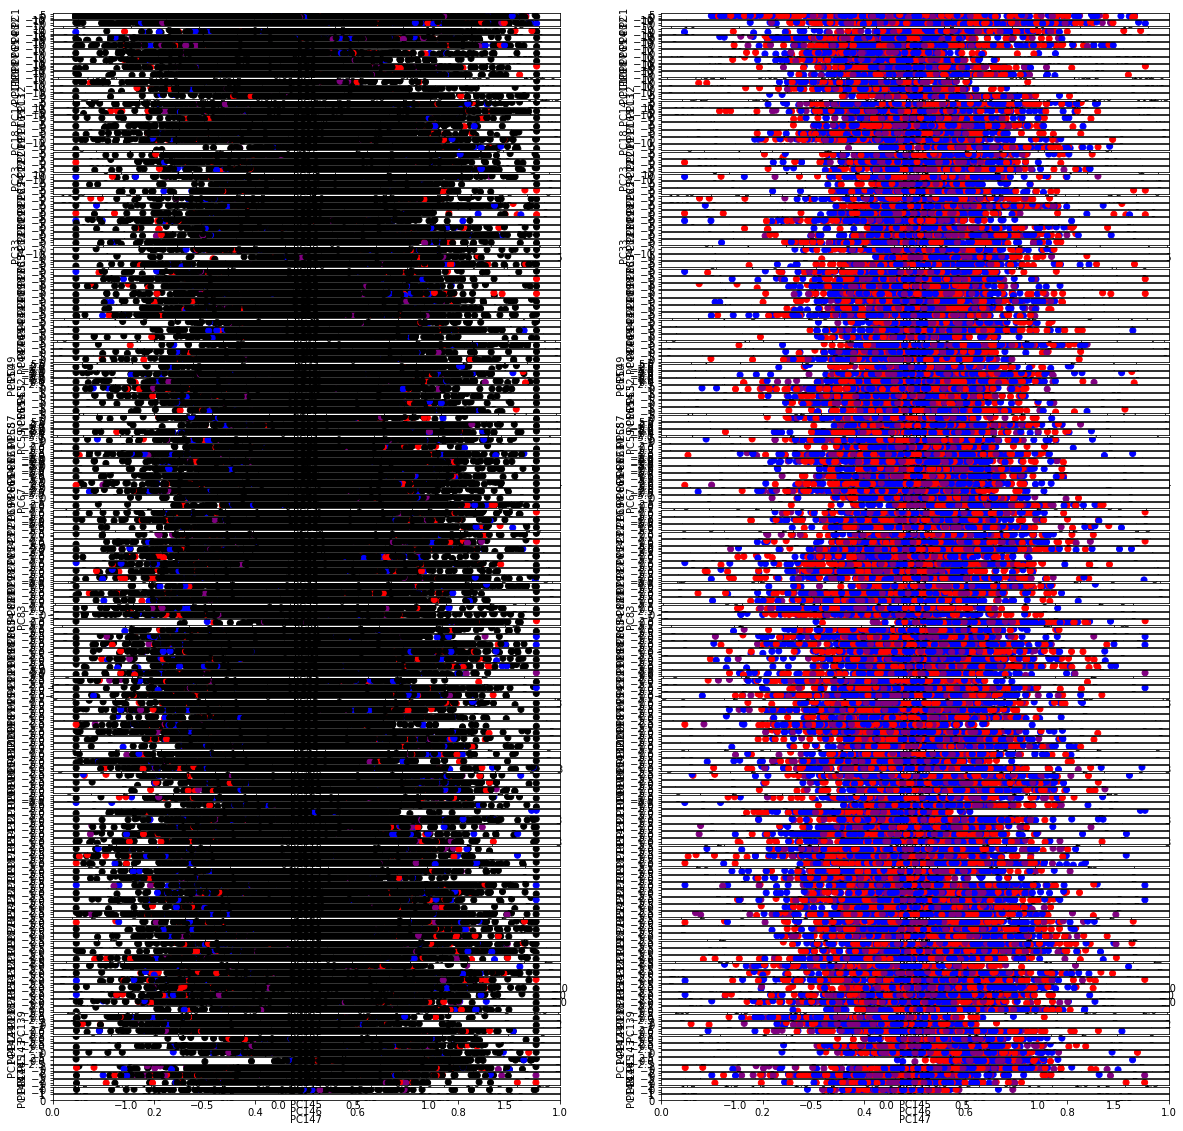

In [372]:
fig,axes = plt.subplots(149,2) 
fig.set_figwidth(20) 
fig.set_figheight(20)
for x in range(149):
    for y in range(2):
        start = x
        slice = (start, start+1)
        if y == 0:
            axes[x,y].scatter(PCs_2_X[:,slice[0]],PCs_2_X[:,slice[1]],
                    color=[['black','red','blue','purple'][i] for i in PCs_2_Y.astype(int)])
            axes[x,y].set_xlabel(str("PC"+str(slice[0])))
            axes[x,y].set_ylabel(str("PC"+str(slice[1])))
        else:
            axes[x,y].scatter(PCs_2_X[:,slice[0]],PCs_2_X[:,slice[1]],
                    color=[['none','red','blue','purple'][i] for i in PCs_2_Y.astype(int)])
            axes[x,y].set_xlabel(str("PC"+str(slice[0])))
            axes[x,y].set_ylabel(str("PC"+str(slice[1])))


            
plt.show()